# Fine-tuning ECAPA-TDNN on  [CryCeleb2023](https://huggingface.co/spaces/competitions/CryCeleb2023) using [SpeechBrain](https://speechbrain.readthedocs.io)

This notebook should help you get started training your own models for CryCeleb2023 challenge.

Note that it is provides basic example for simplicity and speed.

Author: David Budaghyan (Ubenwa)


### Imports

In [ ]:
# For Colab - uncomment and run the following to set up the repo
# !pip install speechbrain
# !git clone https://github.com/Ubenwa/cryceleb2023.git
# %cd cryceleb2023

In [1]:
%%capture
%load_ext autoreload
%autoreload 2

import pathlib
import random

import numpy as np
import pandas as pd
import seaborn as sns
import speechbrain as sb
import torch
from huggingface_hub import hf_hub_download
from hyperpyyaml import load_hyperpyyaml
from IPython.display import display
from speechbrain.dataio.dataio import read_audio, write_audio
from speechbrain.dataio.dataset import DynamicItemDataset
from speechbrain.dataio.encoder import CategoricalEncoder
from speechbrain.lobes.augment import TimeDomainSpecAugment

from crybrain import CryBrain, download_data

dataset_path = "data"

### Download data

You need to log in to HuggingFace to be able to download the dataset

In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
download_data(dataset_path)

In [2]:
# read metadata
metadata = pd.read_csv(
    f"{dataset_path}/metadata.csv", dtype={"baby_id": str, "chronological_index": str}
)
train_metadata = metadata.loc[metadata["split"] != "test"].copy()
display(
    train_metadata.head()
    .style.set_caption("train_metadata")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(train_metadata.describe())

,baby_id,period,duration,split,chronological_index,file_name,file_id
0,0694,B,1.320000,dev,000,audio/dev/0694/B/0694_B_000.wav,0694_B_000
1,0694,B,0.940000,dev,001,audio/dev/0694/B/0694_B_001.wav,0694_B_001
2,0694,B,0.880000,dev,002,audio/dev/0694/B/0694_B_002.wav,0694_B_002
3,0694,B,1.130000,dev,003,audio/dev/0694/B/0694_B_003.wav,0694_B_003
4,0694,B,1.180000,dev,004,audio/dev/0694/B/0694_B_004.wav,0694_B_004


,duration
count,19804.000000
mean,0.883710
std,0.532833
min,0.080000
25%,0.580000
50%,0.770000
75%,1.050000
max,10.340000


In [3]:
dev_babies = set(train_metadata.loc[train_metadata["split"] == "dev", "baby_id"])
print(dev_babies)

{'0214', '0782', '0694', '0786', '0404', '0638', '0584', '1012', '0755', '0122', '0501', '0005', '0751', '0207', '0864', '0294', '0076', '0094', '0789', '0611', '0350', '0114', '0583', '0337', '1071', '0372', '0563', '0774', '0203', '0422', '0292', '0614', '1002', '0737', '0133', '0507', '0593', '0806', '0489', '0327'}


### Concatenate cry sounds

We are given short cry sounds for each baby. Here we simply concatenate them. 

,baby_id,period,duration,file_path,train_split
0,0005,B,43.894000,data/concatenated_audio_train/0005_B.wav,dev
1,0005,D,33.774187,data/concatenated_audio_train/0005_D.wav,dev
2,0006,B,30.170500,data/concatenated_audio_train/0006_B.wav,train
3,0007,B,35.722313,data/concatenated_audio_train/0007_B.wav,train
4,0008,B,55.656375,data/concatenated_audio_train/0008_B.wav,train
...,...,...,...,...,...
1009,1076,B,38.263500,data/concatenated_audio_train/1076_B.wav,train
1010,1076,D,16.064750,data/concatenated_audio_train/1076_D.wav,train
1011,1078,B,10.075750,data/concatenated_audio_train/1078_B.wav,train
1012,1078,D,12.114937,data/concatenated_audio_train/1078_D.wav,train


Text(0.5, 1.0, 'Histogram of Concatenated Cry Sound Lengths')

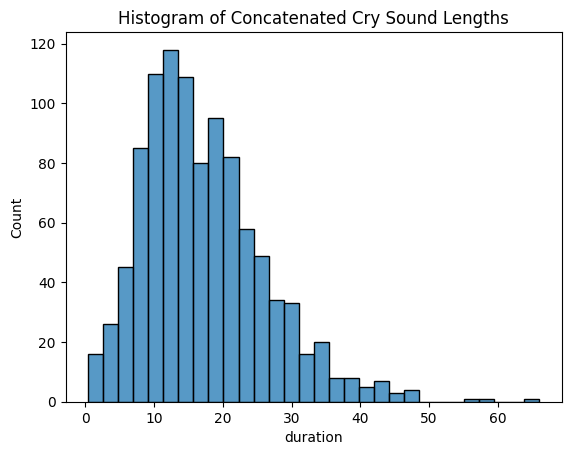

In [4]:
# read the segments
train_metadata["cry"] = train_metadata.apply(
    lambda row: read_audio(f'{dataset_path}/{row["file_name"]}').numpy(), axis=1
)
# concatenate all segments for each (baby_id, period) group
manifest_df = pd.DataFrame(
    train_metadata.groupby(["baby_id", "period"])["cry"].agg(lambda x: np.concatenate(x.values)),
    columns=["cry"],
).reset_index()
# all files have 16000 sampling rate
manifest_df["duration"] = manifest_df["cry"].apply(len) / 16000
pathlib.Path(f"{dataset_path}/concatenated_audio_train").mkdir(exist_ok=True)
manifest_df["file_path"] = manifest_df.apply(
    lambda row: f"{dataset_path}/concatenated_audio_train/{row['baby_id']}_{row['period']}.wav",
    axis=1,
)
manifest_df.apply(
    lambda row: write_audio(
        filepath=f'{row["file_path"]}', audio=torch.tensor(row["cry"]), samplerate=16000
    ),
    axis=1,
)
manifest_df = manifest_df.drop(columns=["cry"])
manifest_df["train_split"] = manifest_df.apply(lambda row: "dev" if row["baby_id"] in dev_babies else "train", axis=1)
display(manifest_df)
ax = sns.histplot(manifest_df, x="duration")
ax.set_title("Histogram of Concatenated Cry Sound Lengths")

During training, we will extract random cuts of 3-5 seconds from concatenated audio

In [9]:
def create_cut_length_interval(row, cut_length_interval):
    """cut_length_interval is a tuple indicating the range of lengths we want our chunks to be.
    this function computes the valid range of chunk lengths for each audio file
    """
    # the lengths are in seconds, convert them to frames
    cut_length_interval = [round(length * 16000) for length in cut_length_interval]
    cry_length = round(row["duration"] * 16000)
    # make the interval valid for the specific sound file
    min_cut_length, max_cut_length = cut_length_interval
    # if min_cut_length is greater than length of cry, don't cut
    if min_cut_length >= cry_length:
        cut_length_interval = (cry_length, cry_length)
    # if max_cut_length is greater than length of cry, take a cut of length between min_cut_length and full length of cry
    elif max_cut_length >= cry_length:
        cut_length_interval = (min_cut_length, cry_length)
    return cut_length_interval


cut_length_interval = (6, 8)
manifest_df["cut_length_interval_in_frames"] = manifest_df.apply(
    lambda row: create_cut_length_interval(row, cut_length_interval=cut_length_interval), axis=1
)

### Split into train and val

For training a classfier, we can split the data into train/val in any way, as long as val does not contain new classes

One way to split is to split by period: train on birth recordings and validate on discharge

In [10]:
# we can train on any subset of babies (e.g. to reduce the number of classes, only keep babies with long enough cries, etc)
def get_babies_with_both_recordings(manifest_df):
    count_of_periods_per_baby = manifest_df.groupby("baby_id")["period"].count()
    baby_ids_with_recording_from_both_periods = count_of_periods_per_baby[
        count_of_periods_per_baby >0
    ].index
    return baby_ids_with_recording_from_both_periods


# def get_babies_with_a_birth_recording(manifest_df):
#   bool_series = manifest_df.groupby('baby_id')['period'].unique().apply(set(['B']).issubset)
#   baby_ids_with_a_recordings_from_birth = bool_series[bool_series].index
#   return baby_ids_with_a_recordings_from_birth


def split_by_period(row, included_baby_ids):
    if row["baby_id"] in included_baby_ids:
        if row["period"] == "D" and row["train_split"] == "dev":
            return "val"
        else:
            return "train"
    else:
        return "not_used"


babies_with_both_recordings = get_babies_with_both_recordings(manifest_df)
manifest_df["split"] = manifest_df.apply(
    lambda row: split_by_period(row, included_baby_ids=babies_with_both_recordings), axis=1
)

# each instance will be identified with a unique id
manifest_df["id"] = manifest_df["baby_id"] + "_" + manifest_df["period"]
display(manifest_df)
display(
    manifest_df["split"]
    .value_counts()
    .rename("use_babies_with_both_recordings_and_split_by_period")
)
manifest_df.set_index("id").to_json("manifest.json", orient="index")

,baby_id,period,duration,file_path,train_split,cut_length_interval_in_frames,split,id
0,0005,B,43.894000,data/concatenated_audio_train/0005_B.wav,dev,"[96000, 128000]",train,0005_B
1,0005,D,33.774187,data/concatenated_audio_train/0005_D.wav,dev,"[96000, 128000]",val,0005_D
2,0006,B,30.170500,data/concatenated_audio_train/0006_B.wav,train,"[96000, 128000]",train,0006_B
3,0007,B,35.722313,data/concatenated_audio_train/0007_B.wav,train,"[96000, 128000]",train,0007_B
4,0008,B,55.656375,data/concatenated_audio_train/0008_B.wav,train,"[96000, 128000]",train,0008_B
...,...,...,...,...,...,...,...,...
1009,1076,B,38.263500,data/concatenated_audio_train/1076_B.wav,train,"[96000, 128000]",train,1076_B
1010,1076,D,16.064750,data/concatenated_audio_train/1076_D.wav,train,"[96000, 128000]",train,1076_D
1011,1078,B,10.075750,data/concatenated_audio_train/1078_B.wav,train,"[96000, 128000]",train,1078_B
1012,1078,D,12.114937,data/concatenated_audio_train/1078_D.wav,train,"[96000, 128000]",train,1078_D


split
train    974
val       40
Name: use_babies_with_both_recordings_and_split_by_period, dtype: int64

### Create dynamic datasets

See SpeechBrain documentation to understand details

In [11]:
# create a dynamic dataset from the csv, only used to create train and val datasets
dataset = DynamicItemDataset.from_json("manifest.json")
baby_id_encoder = CategoricalEncoder()
datasets = {}
# create a dataset for each split
for split in ["train", "val"]:
    # retrieve the desired slice (train or val) and sort by length to minimize amount of padding
    datasets[split] = dataset.filtered_sorted(
        key_test={"split": lambda value: value == split}, sort_key="duration"
    )  # select_n=100
    # create the baby_id_encoded field
    datasets[split].add_dynamic_item(
        baby_id_encoder.encode_label_torch, takes="baby_id", provides="baby_id_encoded"
    )
    # set visible fields
    datasets[split].set_output_keys(["id", "baby_id", "baby_id_encoded", "sig"])


# create the signal field for the val split (no chunking)
datasets["val"].add_dynamic_item(sb.dataio.dataio.read_audio, takes="file_path", provides="sig")

# the label encoder will map the baby_ids to target classes 0, 1, 2, ...
# only use the classes which appear in `train`,
baby_id_encoder.update_from_didataset(datasets["train"], "baby_id")


# for reading the train split, we add chunking
def audio_pipeline(file_path, cut_length_interval_in_frames):
    """Load the signal, and pass it and its length to the corruption class.
    This is done on the CPU in the `collate_fn`."""
    sig = sb.dataio.dataio.read_audio(file_path)
    if cut_length_interval_in_frames is not None:
        cut_length = random.randint(*cut_length_interval_in_frames)
        # pick the start index of the cut
        left_index = random.randint(0, len(sig) - cut_length)
        # cut the signal
        sig = sig[left_index : left_index + cut_length]
    return sig


# create the signal field (with chunking)
datasets["train"].add_dynamic_item(
    audio_pipeline, takes=["file_path", "cut_length_interval_in_frames"], provides="sig"
)

print(datasets["train"][0])

{'id': '0839_D', 'baby_id': '0839', 'baby_id_encoded': tensor([0]), 'sig': tensor([-3.9673e-04, -6.1035e-04, -8.8501e-04,  ..., -6.1035e-05,
         9.1553e-05, -1.8311e-04])}


### Fine-tune the classifier

Here we use a very basic example that just trains for 5 epochs

In [8]:
config_filename = "hparams/ecapa_voxceleb_basic.yaml"
overrides = {
    "seed": 3011,
    "n_classes": len(baby_id_encoder),
    "experiment_name": "ecapa_voxceleb_ft_basic",
    "bs": 32,
    "n_epochs": 125,
}
device = "cuda:0"
run_opts = {"device": device}
###########################################
# Load hyperparameters file with command-line overrides.
with open(config_filename) as fin:
    hparams = load_hyperpyyaml(fin, overrides)

# Create experiment directory
sb.create_experiment_directory(
    experiment_directory=hparams["experiment_dir"],
    hyperparams_to_save=config_filename,
    overrides=overrides,
)

# Initialize the Brain object to prepare for training.
crybrain = CryBrain(
    modules=hparams["modules"],
    opt_class=hparams["opt_class"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)

# if a pretrained model is specified, load it

crybrain.fit(
    epoch_counter=crybrain.hparams.epoch_counter,
    train_set=datasets["train"],
    valid_set=datasets["val"],
    train_loader_kwargs=hparams["train_dataloader_options"],
    valid_loader_kwargs=hparams["val_dataloader_options"],
)

setting seeds to 3011
setting cuda seeds to 3011
lrsched_name: cyclic
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./experiments/ecapa_voxceleb_ft_basic
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 20.9M trainable parameters in CryBrain


RuntimeError: Error(s) in loading state_dict for Classifier:
	size mismatch for weight: copying a param with shape torch.Size([7205, 192]) from checkpoint, the shape in current model is torch.Size([626, 192]).

You can now use embedding_model.ckpt from this recipe and use it in evaluate.ipynb to verify pairs of cries and submit your results!